## 1 预先准备

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

from torchvision.datasets import ImageFolder, CIFAR10
from torchvision import transforms as T

from pytorch_model_summary import summary

from PIL import Image

from time import time

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

import math
import numpy as np
from torchvision.utils import make_grid
from torchvision.io import read_image

from collections import OrderedDict

from datetime import datetime
from pathlib import Path

import shutil

from scipy.signal import savgol_filter

assert torch.cuda.is_available()
device = "cuda"

data_path = "../../data"

## 2 BIRDS-525
### 2.1 简述
受机能限制，我们使用 [BIRDS 525 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) 数据集作为 ImageNet 的替代，验证模型效果。该数据集包含 $8\ 4635$ 张训练图、$2625$ 张测试图、$2625$ 张验证图，每张图为 $224 \times 224$ 大小的 RGB 图像，代表了 $525$ 种鸟类的其中一种。该数据集使用 CC0 协议。

![可爱的小鸟图像](train_ABBOTTS_BABBLER_001.jpg)

原论文使用的 ImageNet 2012 训练集有 $128\ 0000$ 张训练图、$10\ 0000$ 张测试图和 $5\ 0000$ 张验证图，有 $1000$ 个分类。相比而言，前者的数据规模、图像大小和分类数与后者都较为相近，且规模较适宜，可以作为简单的参考。

再次地，受机能限制，我们将 batch size 设为 $64$，运行约 $1.3$ 万个迭代，并在第 $1$ 万个迭代处将学习率除以 $10$。同时，图像处理方法为：

1. 将图像缩放到 $224 \times 224$ 大小；
2. 将图像减去放缩后的平均输入图像；
3. 随机截取 $160 \times 160$ 的子图；
4. 随机决定是否水平翻转。

输入大小变为 $3 \times 160 \times 160$，模型架构基本不变，仅改变了每一层输入的图像大小（由 $224 - 112 - 56 - 28 - 14 - 7 - 1$ 变为 $160 - 80 - 40 - 20 - 10 - 5$）。

### 2.2 加载数据，并计算平均输入图像

In [2]:
# # 计算平均输入 image
# transform = T.Compose([
#     T.Resize((224, 224), antialias=True),
#     T.RandomHorizontalFlip(),
#     T.ToTensor(),
# ])
# train_data = ImageFolder(root=f"{data_path}/birds525/train", transform=transform)
# train_dataloader = DataLoader(train_data, batch_size=1024)

# avg_img = torch.zeros((3, 224, 224))

# st_time = time()
# count = 0
# total = len(train_data)
# for imgs, labels in train_dataloader:
#     avg_img += torch.sum(imgs, 0)

#     count += len(labels)
#     print(f"{count / total * 100:<6.1f}%      {(time() - st_time) / count * 1000000:<4.0f}μs/image")
# avg_img /= len(train_data)

# T.ToPILImage()(avg_img).save(f"model/bird525-train-mean.jpg")

avg_img = T.ToTensor()(Image.open("model/bird525-train-mean.jpg"))

# 重新载入
batch_size = 64
real_batch_size = 64
transform = T.Compose([
    T.Resize((224, 224), antialias=True),
    T.ToTensor(),
    T.Lambda(lambda x: x - avg_img),
    T.RandomCrop((192, 192)),
    T.RandomHorizontalFlip(),
])

train_data = ImageFolder(root=f"{data_path}/birds525/train", transform=transform)
val_data = ImageFolder(root=f"{data_path}/birds525/valid", transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=4, pin_memory=True)

### 2.3 训练集处理后图像预览

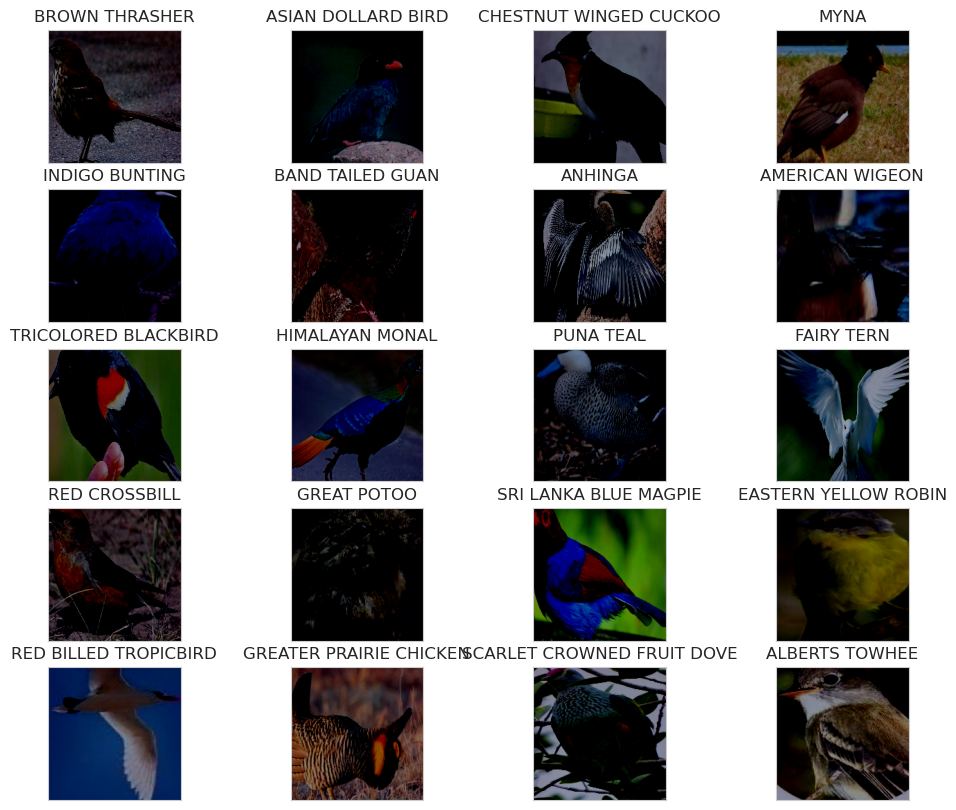

In [3]:
preview_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)

for X, y in preview_dataloader:
    break

def show_imgs(imgs, labels, nrows, ncols, **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, **kwargs)
    for i in range(imgs.shape[0]):
        g = ax[i // ncols, i % ncols]
        g.imshow(torch.maximum(imgs[i], torch.zeros_like(imgs[i])).permute(1, 2, 0))
        g.set_title(train_data.classes[labels[i]])
    for i in range(nrows):
        for j in range(ncols):
            ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show(fig)

show_imgs(X, y, 5, 4, figsize=(12, 10))

### 2.4 定义类 BlockPair、BlockPairs 和 ResNet
`BlockPair` 类为 Res-18 和 Res-34 使用的单组残差计算块，含有两个卷积层、BN 层和捷径链接。`res_type` 决定捷径的计算方式。

* 当 `res_type = 0`：无捷径连接，此时等价于朴素 CNN。
* 当 `res_type = 1`：当维数不变时使用恒等变换，当维数变化时剪切后进行恒等变换，新增的 fliter 层全部填充为 $0$。
* 当 `res_type = 2`：当维数不变时使用恒等变换，当维数变化时使用 $1 \times 1$ 卷积（即线性变换）。
* 当 `res_type = 3`：固定使用 $1 \times 1$ 卷积（即线性变换）。
* 当 `res_type = 4`：当维数不变时使用恒等变换，当维数变化时使用核大小为 $2 \times 2$、步长为 $2$ 的平均池化层进行变换，新增的 fliter 层全部填充为 $0$。

`BlockPairs` 类为多个 `BlockPair` 的线性组合。

`ResNet` 类为 ResNet 模型，`conv_nums` 决定每一个分辨率级别的 `BlockPairs` 有多少个。

In [4]:
class BlockPair(nn.Module):
    def __init__(self, out_channels, stride, res_type):
        assert res_type != 3
        
        super().__init__()
        self.res_type = res_type
        self.stack = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(in_channels=out_channels // stride, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)),
            ("conv1_bn", nn.BatchNorm2d(out_channels)),
            ("conv1_relu", nn.ReLU(inplace=True)),
            ("conv2", nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)),
            ("conv2_bn", nn.BatchNorm2d(out_channels)),
        ]))
        if res_type == 2 and stride == 2:
            self.shortcut = nn.Sequential(
                ("conv", nn.Conv2d(in_channels=out_channels // stride, out_channels=out_channels, kernal_size=1, stride=2, bias=False)),
                ("bn", nn.BatchNorm2d(out_channels)),
            )

    def forward(self, x):
        out = self.stack(x)
        if self.res_type != 0:
            if out.shape != x.shape:
                if self.res_type == 1:
                    out[:, :x.shape[1], :, :] += x[:, :, :out.shape[2], :out.shape[3]]
                elif self.res_type == 4:
                    out[:, :x.shape[1], :, :] += F.avg_pool2d(x, kernel_size=2, stride=2)
                else:
                    out += self.shortcut(x)
            else:
                out += x
        return F.relu(out, inplace=True)

class BlockPairs(nn.Module):
    def __init__(self, out_channels, num, stride, res_type):
        super().__init__()
        self.stack = nn.Sequential(
            BlockPair(out_channels=out_channels, stride=stride, res_type=res_type),
            *[BlockPair(out_channels=out_channels, stride=1, res_type=res_type) for i in range(num - 1)]
        )


    def forward(self, x):
        return self.stack(x)

class ResNet(nn.Module):
    def __init__(self, conv_nums, res_type):
        super().__init__()
        self.stack = nn.Sequential(OrderedDict([
            ("conv", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)),
            ("conv_bn", nn.BatchNorm2d(64)),
            ("conv_relu", nn.ReLU(inplace=True)),
            ("maxpool", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),

            ("blockpairs", nn.Sequential(
                BlockPairs(out_channels=64, num=conv_nums[0], stride=1, res_type=res_type),
                BlockPairs(out_channels=128, num=conv_nums[1], stride=2, res_type=res_type),
                BlockPairs(out_channels=256, num=conv_nums[2], stride=2, res_type=res_type),
                BlockPairs(out_channels=512, num=conv_nums[3], stride=2, res_type=res_type),
            )),

            ("avgpool", nn.AvgPool2d(kernel_size=6)),
            ("avgpool_flatten", nn.Flatten()),
            ("fc", nn.Linear(in_features=512, out_features=525, bias=True)),
        ]))

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, 0, math.sqrt(2) / module.kernel_size[0])
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.stack(x)

    def predict_proba(self, x):
        if x.dim() == 3:
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        return F.softmax(self.stack(x), dim=1)

### 2.5 定义常用函数、测试函数和训练函数

In [5]:
def timeprint(*args, **kwargs):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]", end=' ')
    print(*args, **kwargs)

def get_optimizer(model):
    return torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)

def test(dataloader, model, verbose):
    model.eval()
    
    loss_fn = nn.CrossEntropyLoss()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = float(test_loss) / num_batches
    correct = float(correct) / size

    if verbose:
        timeprint(f"Test Error: \n Accuracy: {(100*correct):>0.4f}%, Avg loss: {test_loss:>8f} \n")

    return {"acc": correct, "loss": test_loss}


def _train(dataloader, model, optimizer, scheduler, base_n_iter, val_dataloader, n_val_iter):
    data = pd.DataFrame(columns=["n_iter", "loss", "acc", "dataset"])

    loss_fn = nn.CrossEntropyLoss()
    
    size = len(dataloader.dataset)
    model.train()

    total_loss = 0
    total_acc = 0
    n_iter = base_n_iter
    count = 0
    total_count = 0
    
    max_n_iter = size // real_batch_size

    optimizer.zero_grad()
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += float(loss.item() * len(y))
        total_acc += float((pred.argmax(1) == y).type(torch.float).sum().item())

        total_count += len(y)
        count += len(y)

        loss /= (real_batch_size // batch_size)
        loss.backward()


        if count >= real_batch_size:
            n_iter += 1
            total_loss /= count
            total_acc /= count
            count = 0

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            if (n_iter - 1) * 50 // max_n_iter != n_iter * 50 // max_n_iter:
                timeprint(f"train (batch) loss: {total_loss:>8f}   acc: {total_acc*100:>0.4f}%   [{total_count:>5d}/{size:>5d}]   total n_iter: {n_iter}")
                
                data.loc[len(data)] = {
                    "n_iter": n_iter,
                    "loss": total_loss,
                    "acc": total_acc,
                    "dataset": "train",
                }

            total_acc = 0
            total_loss = 0
            
            if (n_iter - 1) // n_val_iter != n_iter // n_val_iter:
                val_res = test(val_dataloader, model, verbose=False)
                model.train()
                val_loss = val_res["loss"]
                val_acc = val_res["acc"]
                timeprint(f"    val (full)    loss: {val_loss:>8f}   acc: {val_acc*100:>0.4f}%   [{total_count:>5d}/{size:>5d}]   total n_iter: {n_iter}")
                data.loc[len(data)] = {
                    "n_iter": n_iter,
                    "loss": val_loss,
                    "acc": val_acc,
                    "dataset": "val",
                }
    return data


def show_training_history(history):
    history["n_iter"] = history["n_iter"].astype("int")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    g = sns.lineplot(history, x="n_iter", y="loss", hue="dataset", ax=ax[0]) 
    g.set_title("loss")
    g = sns.lineplot(history, x="n_iter", y="acc", hue="dataset", ax=ax[1]) 
    g.set_title("acc")
    plt.show(fig)


def train_model(model, name, epoch_start, epoch_end, train_dataloader, val_dataloader, get_optimizer, get_scheduler):
    Path(f"model/{name}").mkdir(parents=True, exist_ok=True)

    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)
    history = pd.DataFrame(columns=["n_iter", "loss", "acc", "dataset"])

    if epoch_start != 1:
        checkpoint = torch.load(f"model/{name}/ver{epoch_start - 1}_checkpoint")
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])
        history = pd.read_csv(f"model/{name}/ver{epoch_start - 1}_history.csv")
    

    for t in range(epoch_start, epoch_end + 1):
        timeprint(f"Epoch {t}\n-------------------------------")
        new_history = _train(train_dataloader, model, optimizer, scheduler, base_n_iter=(t - 1) * (len(train_data) // real_batch_size), val_dataloader=val_dataloader, n_val_iter=max(1, len(val_data) // real_batch_size))
        history = pd.concat((history, new_history))

        checkpoint = {
            "epoch": t, 
            "name": name,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }

        torch.save(checkpoint, f"model/{name}/ver{t}_checkpoint")
        history.to_csv(f"model/{name}/ver{t}_history.csv")

def show_model_test(model, name, ver):
    model.load_state_dict(torch.load(f"model/{name}/{ver}_checkpoint")["model"])

    test(val_dataloader, model, verbose=True)

    show_training_history(pd.read_csv(f"model/{name}/{ver}_history.csv"))

### 2.6 训练

#### 2.6.1 Plain-18

In [6]:
plain_18 = ResNet([2, 2, 2, 2], res_type=0)
timeprint(summary(plain_18, torch.zeros(1, 3, 192, 192), max_depth=2, show_hierarchical=True))

[2023-08-17 14:10:37] ------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 64, 96, 96]           9,408           9,408
     BatchNorm2d-2      [1, 64, 96, 96]             128             128
            ReLU-3      [1, 64, 96, 96]               0               0
       MaxPool2d-4      [1, 64, 48, 48]               0               0
       BlockPair-5      [1, 64, 48, 48]          73,984          73,984
       BlockPair-6      [1, 64, 48, 48]          73,984          73,984
       BlockPair-7     [1, 128, 24, 24]         221,696         221,696
       BlockPair-8     [1, 128, 24, 24]         295,424         295,424
       BlockPair-9     [1, 256, 12, 12]         885,760         885,760
      BlockPair-10     [1, 256, 12, 12]       1,180,672       1,180,672
      BlockPair-11       [1, 512, 6, 6]       3,540,992       3,540,992
      BlockPair-12       [1, 512, 6, 6]  

In [7]:
# plain_18 = plain_18.to(device)
# train_model(plain_18, "plain_18", 1, 10, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy("model/plain_18/ver10_checkpoint", "model/plain_18/final_checkpoint")
# shutil.copy("model/plain_18/ver10_history.csv", "model/plain_18/final_history.csv")
# show_model_test(plain_18, "plain_18", "final")
del plain_18

此处使用 Plain-18 达到了 $27\%$ 左右的错误率，与论文里给出的 $27.94\%$ 相近，说明我们使用的训练集和训练方法确实是相对有效的，可以进行进一步的训练和计算。

#### 2.6.2 ResNet-18

In [8]:
# res_18 = ResNet([2, 2, 2, 2], res_type=1).to(device)
# train_model(res_18, "res_18", 1, 10, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy("model/res_18/ver10_checkpoint", "model/res_18/final_checkpoint")
# shutil.copy("model/res_18/ver10_history.csv", "model/res_18/final_history.csv")
# show_model_test(res_18, "res_18", "final")
# del res_18

#### 2.6.3 Plain-34

In [9]:
# plain_34 = ResNet([3, 4, 6, 3], res_type=0).to(device)
# train_model(plain_34, "plain_34", 1, 10, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy("model/plain_34/ver10_checkpoint", "model/plain_34/final_checkpoint")
# shutil.copy("model/plain_34/ver10_history.csv", "model/plain_34/final_history.csv")
# show_model_test(plain_34, "plain_34", "final")
# del plain_34

#### 2.6.4 ResNet-34

In [10]:
# res_34 = ResNet([3, 4, 6, 3], res_type=1).to(device)
# train_model(res_34, "res_34", 1, 10, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy("model/res_34/ver10_checkpoint", "model/res_34/final_checkpoint")
# shutil.copy("model/res_34/ver10_history.csv", "model/res_34/final_history.csv")
# show_model_test(res_34, "res_34", "final")
# del res_34

### 2.7 总览

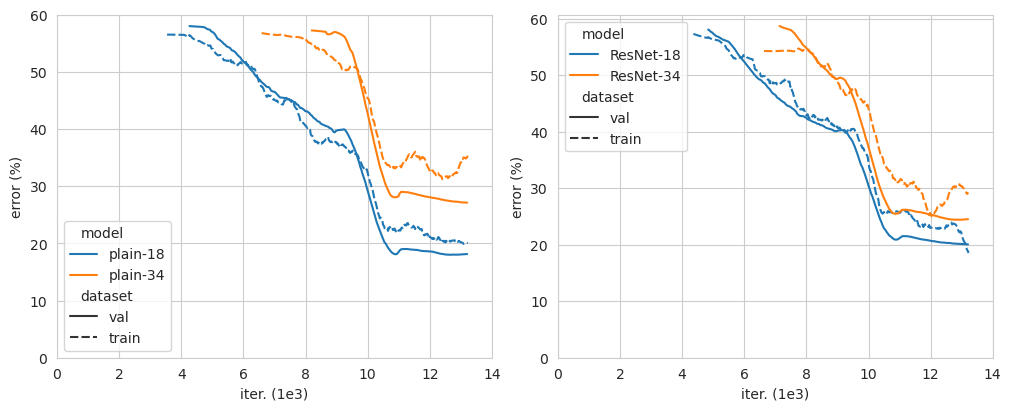

In [11]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))

for i, (name, show_name) in enumerate([("plain", "plain"), ("res", "ResNet")]):
    total_history = pd.DataFrame(columns=["n_iter", "error", "dataset", "model"])
    for n_layer in [18, 34]:
        history = pd.read_csv(f"model/{name}_{n_layer}/final_history.csv")

        history["model"] = f"{show_name}-{n_layer}"
        history["n_iter"] /= 1e3
        history["error"] = 100 - history["acc"] * 100

        total_history = pd.concat((total_history, history[history["error"] <= 60]))

    total_history.index = list(range(len(total_history)))

    for _, ids in total_history.groupby(["model", "dataset"]).groups.items():
        errs = total_history.loc[ids, "error"]
        total_history.loc[ids, "error"] = savgol_filter(errs, window_length=51, polyorder=3, mode="nearest")

    g = sns.lineplot(total_history, x="n_iter", y="error", hue="model", style="dataset", style_order=["val", "train"], ax=ax[i])
    g.set(xlabel="iter. (1e3)", ylabel="error (%)", xticks=[0, 2, 4, 6, 8, 10, 12, 14], yticks=[60, 50, 40, 30, 20, 10, 0])

plt.show()

从测试集效果来看，可见准确率 plain-18 > ResNet-18 > ResNet-34 > plain-34。

这一现象和论文不符，推测是因为 batch size、迭代数、学习率调整方式、数据集都与原论文不同导致的偏差。

限于机能和网络，无法对此进行进一步的探究。

### 2.8 效果预览
使用 Res-18 作为模型。

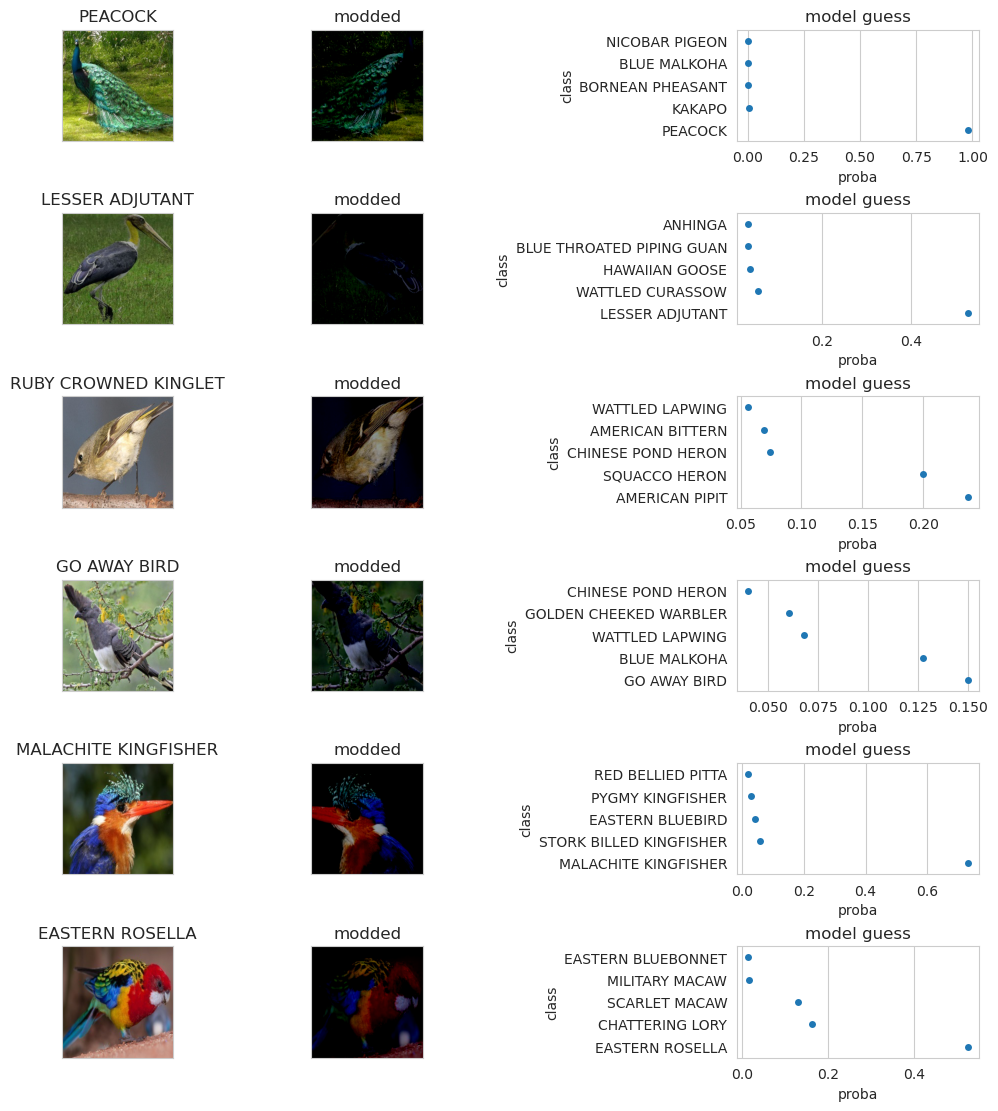

In [12]:
res_18 = ResNet([2, 2, 2, 2], res_type=4)
res_18.load_state_dict(torch.load("model/res_18/final_checkpoint")["model"])
res_18.eval()

num = 6

preview_val_data = ImageFolder(root=f"{data_path}/birds525/valid", transform=T.ToTensor())
preview_dataloader = DataLoader(preview_val_data, batch_size=num, shuffle=True)

fig, ax = plt.subplots(nrows=num, ncols=3, figsize=(10, int(1.8 * num) + 1), constrained_layout=True)

for X, y in preview_dataloader:
    break

for i in range(num):
    ax[i, 0].imshow(X[i].permute(1, 2, 0))
    ax[i, 0].set(title=val_data.classes[int(y[i])], xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    X_mod = transform(T.ToPILImage()(X[i]))
    ax[i, 1].imshow(torch.maximum(X_mod, torch.zeros_like(X_mod)).permute(1, 2, 0))
    ax[i, 1].set(title="modded", xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    proba = res_18.predict_proba(X_mod)[0]
    data = pd.DataFrame(columns=["class", "proba"])
    
    for x in torch.argsort(proba)[-5:]:
        data.loc[len(data)] = {
            "class": val_data.classes[int(x)],
            "proba": float(proba[x]),
        }

    sns.stripplot(data, x="proba", y="class", ax=ax[i, 2])
    ax[i, 2].set_title("model guess")
plt.show(fig)

## 3 CIFAR-10

### 3.1 概述
由于 CIFAR-10 数据集较小，迭代次数少，所以我们可以直接按照论文给定的参数进行复现。

### 3.2 加载数据，并计算平均输入图像

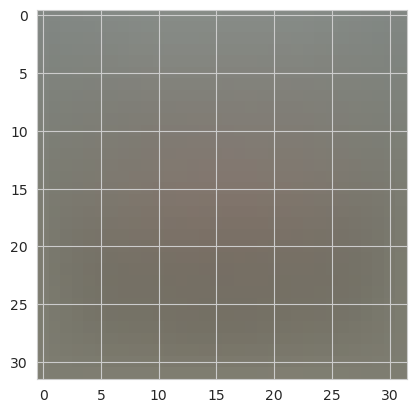

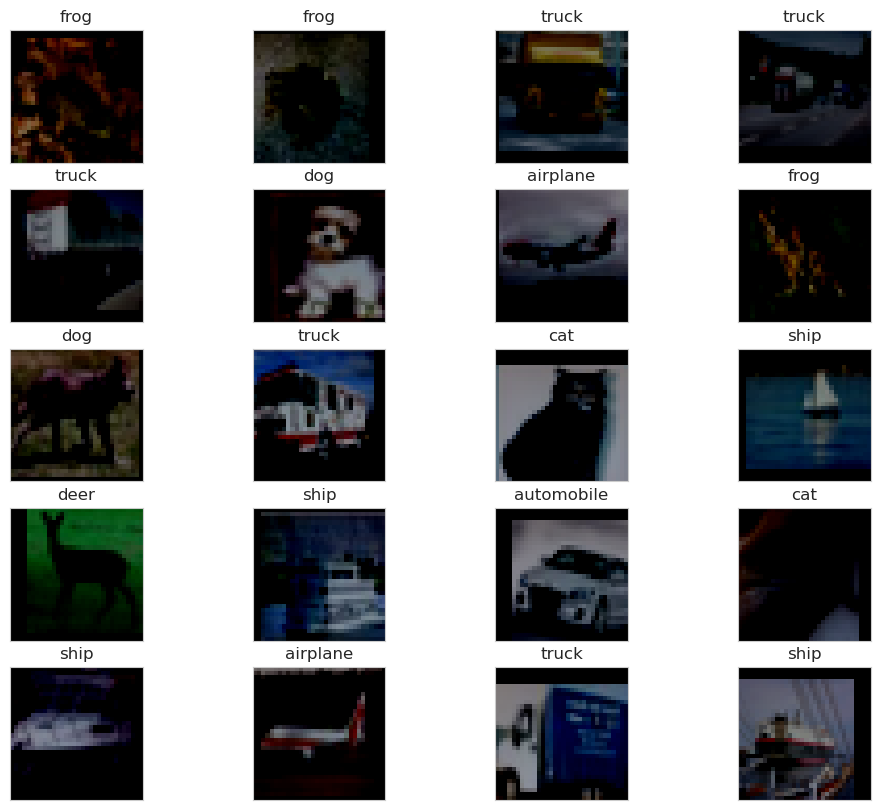

In [13]:
batch_size = 128
real_batch_size = 128




data_full = CIFAR10(root=data_path, train=True, transform=T.ToTensor(), download=False)
classes = data_full.classes

val_indices = []
train_indices = []

val_counts = [500] * 10
for idx, (X, y) in enumerate(data_full):
    if val_counts[y] > 0:
        val_indices.append(idx)
        val_counts[y] -= 1
    else:
        train_indices.append(idx)

train_data = torch.utils.data.Subset(data_full, train_indices)

avg_dataloader = DataLoader(train_data, batch_size=45000, num_workers=20)
for X, y in avg_dataloader:
    avg_img = torch.sum(X, 0) / 45000

del data_full
del avg_dataloader
del train_data

train_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x - avg_img),
    T.Pad(padding=4),
    T.RandomCrop((32, 32)),
    T.RandomHorizontalFlip(),
])
val_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x - avg_img),
    T.RandomHorizontalFlip(),
])

train_data = CIFAR10(root=data_path, train=True, transform=train_transform, download=False)
train_data = torch.utils.data.Subset(train_data, train_indices)
train_data.classes = classes

val_data = CIFAR10(root=data_path, train=True, transform=val_transform, download=False)
val_data = torch.utils.data.Subset(val_data, val_indices)
val_data.classes = classes

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=1000, shuffle=True, num_workers=4, pin_memory=True)

preview_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)

for X, y in preview_dataloader:
    break

plt.imshow(T.ToPILImage()(avg_img))
show_imgs(X, y, 5, 4, figsize=(12, 10))

### 3.3 定义类 ResNetCIFAR10

In [14]:
class ResNetCIFAR10(nn.Module):
    def __init__(self, conv_num, res_type):
        super().__init__()
        self.stack = nn.Sequential(OrderedDict([
            ("conv", nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)),
            ("conv_bn", nn.BatchNorm2d(16)),
            ("conv_relu", nn.ReLU(inplace=True)),

            ("blockpairs", nn.Sequential(
                BlockPairs(out_channels=16, num=conv_num, stride=1, res_type=res_type),
                BlockPairs(out_channels=32, num=conv_num, stride=2, res_type=res_type),
                BlockPairs(out_channels=64, num=conv_num, stride=2, res_type=res_type),
            )),

            ("avgpool", nn.AvgPool2d(kernel_size=8)),
            ("avgpool_flatten", nn.Flatten()),
            ("fc", nn.Linear(in_features=64, out_features=10, bias=True)),
        ]))

        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, 0, math.sqrt(2) / module.kernel_size[0])
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.stack(x)

    def predict_proba(self, x):
        if x.dim() == 3:
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        return F.softmax(self.stack(x), dim=1)

def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)


def _lr_lambda_110(n_iter):
    if n_iter <= 450:
        return 0.1
    elif n_iter <= 32000:
        return 1
    elif n_iter <= 48000:
        return 0.1
    else:
        return 0.01
    
def get_scheduler_110(optimizer):
    return torch.optim.lr_scheduler.LambdaLR(optimizer, _lr_lambda_110)

### 3.4 训练模型
#### 3.4.1 plain-20

In [15]:
plain_20_cifar = ResNetCIFAR10(3, res_type=0)
timeprint(summary(plain_20_cifar, torch.zeros(1, 3, 32, 32), max_depth=2, show_hierarchical=True))

[2023-08-17 14:10:45] -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 16, 32, 32]             432             432
     BatchNorm2d-2     [1, 16, 32, 32]              32              32
            ReLU-3     [1, 16, 32, 32]               0               0
       BlockPair-4     [1, 16, 32, 32]           4,672           4,672
       BlockPair-5     [1, 16, 32, 32]           4,672           4,672
       BlockPair-6     [1, 16, 32, 32]           4,672           4,672
       BlockPair-7     [1, 32, 16, 16]          13,952          13,952
       BlockPair-8     [1, 32, 16, 16]          18,560          18,560
       BlockPair-9     [1, 32, 16, 16]          18,560          18,560
      BlockPair-10       [1, 64, 8, 8]          55,552          55,552
      BlockPair-11       [1, 64, 8, 8]          73,984          73,984
      BlockPair-12       [1, 64, 8, 8]          73,984

In [16]:
n_epoch = 183
# plain_20_cifar = plain_20_cifar.to(device)
# train_model(plain_20_cifar, "plain_20_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/plain_20_cifar/ver{n_epoch}_checkpoint", "model/plain_20_cifar/final_checkpoint")
# shutil.copy(f"model/plain_20_cifar/ver{n_epoch}_history.csv", "model/plain_20_cifar/final_history.csv")
# show_model_test(plain_20_cifar, "plain_20_cifar", "final")
del plain_20_cifar

#### 3.4.2 res-20

In [17]:
# res_20_cifar = ResNetCIFAR10(3, res_type=1).to(device)
# train_model(res_20_cifar, "res_20_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/res_20_cifar/ver{n_epoch}_checkpoint", "model/res_20_cifar/final_checkpoint")
# shutil.copy(f"model/res_20_cifar/ver{n_epoch}_history.csv", "model/res_20_cifar/final_history.csv")
# show_model_test(res_20_cifar, "res_20_cifar", "final")
# del res_20_cifar

#### 3.4.3 plain-32

In [18]:
# plain_32_cifar = ResNetCIFAR10(5, res_type=0).to(device)
# train_model(plain_32_cifar, "plain_32_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/plain_32_cifar/ver{n_epoch}_checkpoint", "model/plain_32_cifar/final_checkpoint")
# shutil.copy(f"model/plain_32_cifar/ver{n_epoch}_history.csv", "model/plain_32_cifar/final_history.csv")
# show_model_test(plain_32_cifar, "plain_32_cifar", "final")
# del plain_32_cifar

#### 3.4.4 res-32

In [19]:
# res_32_cifar = ResNetCIFAR10(5, res_type=1).to(device)
# train_model(res_32_cifar, "res_32_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/res_32_cifar/ver{n_epoch}_checkpoint", "model/res_32_cifar/final_checkpoint")
# shutil.copy(f"model/res_32_cifar/ver{n_epoch}_history.csv", "model/res_32_cifar/final_history.csv")
# show_model_test(res_32_cifar, "res_32_cifar", "final")
# del res_32_cifar

#### 3.4.5 plain-44

In [20]:
# plain_44_cifar = ResNetCIFAR10(7, res_type=0).to(device)
# train_model(plain_44_cifar, "plain_44_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/plain_44_cifar/ver{n_epoch}_checkpoint", "model/plain_44_cifar/final_checkpoint")
# shutil.copy(f"model/plain_44_cifar/ver{n_epoch}_history.csv", "model/plain_44_cifar/final_history.csv")
# show_model_test(plain_44_cifar, "plain_44_cifar", "final")
# del plain_44_cifar

#### 3.4.6 res-44

In [21]:
# res_44_cifar = ResNetCIFAR10(7, res_type=1).to(device)
# train_model(res_44_cifar, "res_44_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/res_44_cifar/ver{n_epoch}_checkpoint", "model/res_44_cifar/final_checkpoint")
# shutil.copy(f"model/res_44_cifar/ver{n_epoch}_history.csv", "model/res_44_cifar/final_history.csv")
# show_model_test(res_44_cifar, "res_44_cifar", "final")
# del res_44_cifar

#### 3.4.7 plain-56

In [22]:
# plain_56_cifar = ResNetCIFAR10(9, res_type=0).to(device)
# train_model(plain_56_cifar, "plain_56_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/plain_56_cifar/ver{n_epoch}_checkpoint", "model/plain_56_cifar/final_checkpoint")
# shutil.copy(f"model/plain_56_cifar/ver{n_epoch}_history.csv", "model/plain_56_cifar/final_history.csv")
# show_model_test(plain_56_cifar, "plain_56_cifar", "final")
# del plain_56_cifar

#### 3.4.8 res-56

In [23]:
# res_56_cifar = ResNetCIFAR10(9, res_type=1).to(device)
# train_model(res_56_cifar, "res_56_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler)
# shutil.copy(f"model/res_56_cifar/ver{n_epoch}_checkpoint", "model/res_56_cifar/final_checkpoint")
# shutil.copy(f"model/res_56_cifar/ver{n_epoch}_history.csv", "model/res_56_cifar/final_history.csv")
# show_model_test(res_56_cifar, "res_56_cifar", "final")
# del res_56_cifar

#### 3.4.9 res-110

[2023-08-17 14:10:46] Epoch 1
-------------------------------
[2023-08-17 14:10:48] train (batch) loss: 4.451555   acc: 8.5938%   [ 1024/45000]   total n_iter: 8
[2023-08-17 14:10:49] train (batch) loss: 2.809627   acc: 10.9375%   [ 1920/45000]   total n_iter: 15
[2023-08-17 14:10:49] train (batch) loss: 2.830547   acc: 12.5000%   [ 2816/45000]   total n_iter: 22
[2023-08-17 14:10:50] train (batch) loss: 2.335371   acc: 18.7500%   [ 3712/45000]   total n_iter: 29
[2023-08-17 14:10:50] train (batch) loss: 2.743439   acc: 18.7500%   [ 4608/45000]   total n_iter: 36
[2023-08-17 14:10:52]     val (full)    loss: 3.165830   acc: 13.5200%   [ 4992/45000]   total n_iter: 39
[2023-08-17 14:10:52] train (batch) loss: 2.682771   acc: 11.7188%   [ 5504/45000]   total n_iter: 43
[2023-08-17 14:10:53] train (batch) loss: 2.428064   acc: 15.6250%   [ 6400/45000]   total n_iter: 50
[2023-08-17 14:10:53] train (batch) loss: 2.518171   acc: 11.7188%   [ 7296/45000]   total n_iter: 57
[2023-08-17 14:10:

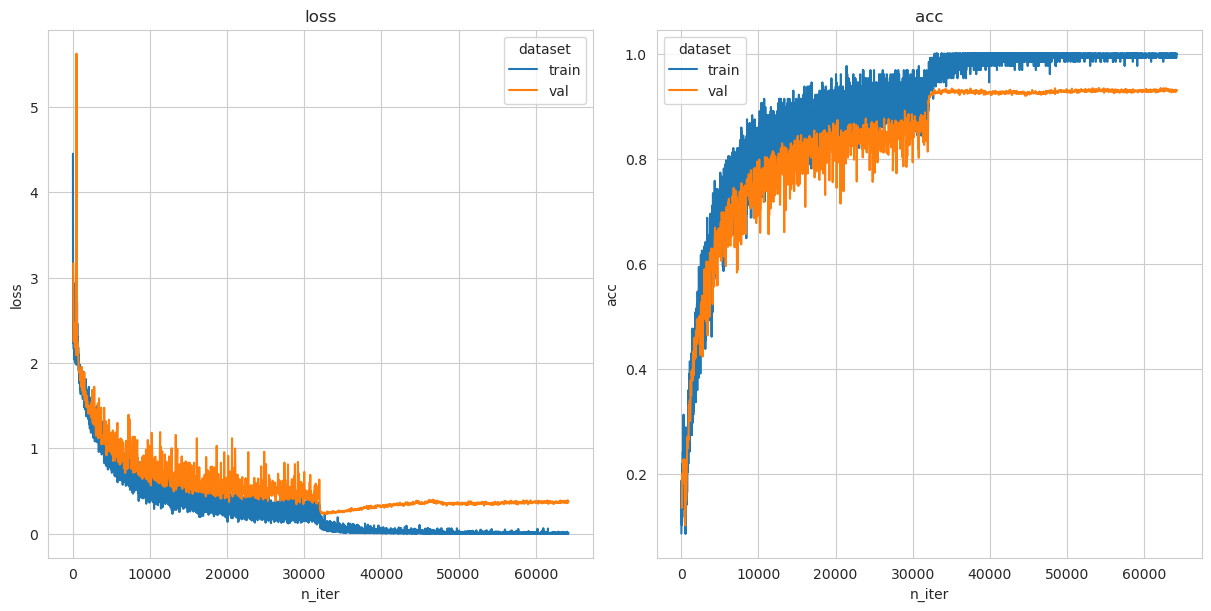

In [24]:
# res_110_cifar = ResNetCIFAR10(18, res_type=1).to(device)
# train_model(res_110_cifar, "res_110_cifar", 1, n_epoch, train_dataloader, val_dataloader, get_optimizer, get_scheduler_110)
# shutil.copy(f"model/res_110_cifar/ver{n_epoch}_checkpoint", "model/res_110_cifar/final_checkpoint")
# shutil.copy(f"model/res_110_cifar/ver{n_epoch}_history.csv", "model/res_110_cifar/final_history.csv")
# show_model_test(res_110_cifar, "res_110_cifar", "final")
# del res_110_cifar

### 3.5 总览

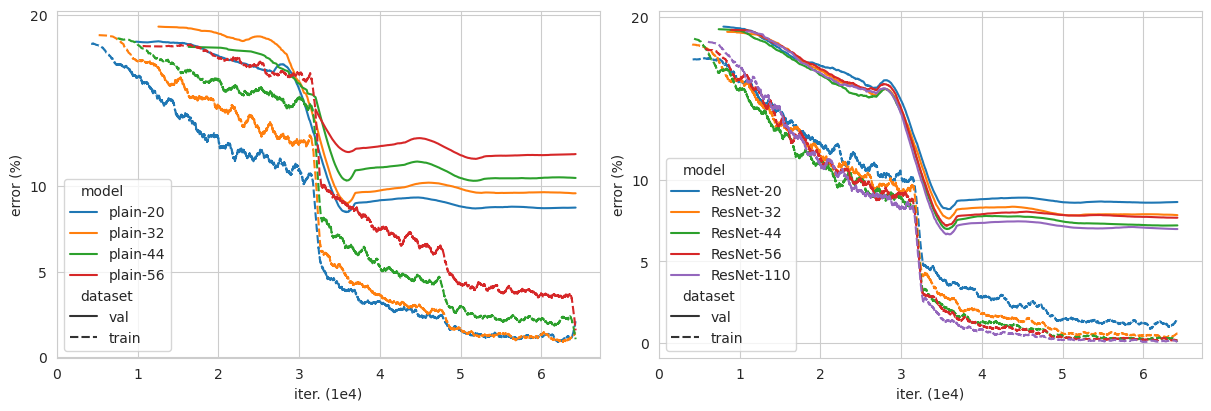

In [25]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

for i, (name, show_name) in enumerate([("plain", "plain"), ("res", "ResNet")]):
    total_history = pd.DataFrame(columns=["n_iter", "error", "dataset", "model"])

    for n_layer in [20, 32, 44, 56, 110]:
        if name == "plain" and n_layer == 110:
            continue
        history = pd.read_csv(f"model/{name}_{n_layer}_cifar/final_history.csv")

        history["model"] = f"{show_name}-{n_layer}"
        history["n_iter"] /= 1e4
        history["error"] = 100 - history["acc"] * 100

        total_history = pd.concat((total_history, history[history["error"] <= 20]))

    total_history.index = list(range(len(total_history)))

    for _, ids in total_history.groupby(["model", "dataset"]).groups.items():
        errs = total_history.loc[ids, "error"]
        total_history.loc[ids, "error"] = savgol_filter(errs, window_length=251, polyorder=3, mode="nearest")

    g = sns.lineplot(total_history, x="n_iter", y="error", hue="model", style="dataset", style_order=["val", "train"], ax=ax[i])
    g.set(xlabel="iter. (1e4)", ylabel="error (%)", xticks=[0, 1, 2, 3, 4, 5, 6], yticks=[20, 10, 5, 0])
plt.show()

这一结果和论文结果基本相符：朴素 CNN 的错误率随层数增加而增加，ResNet 的错误率随层数增加而减少，且 ResNet 的表现基本优于朴素 CNN 的表现。

### 3.6 效果预览

下面的预览使用模型为 Res-110，直接从 $10^4$ 个测试集数据中选取 $10$ 个进行预测。

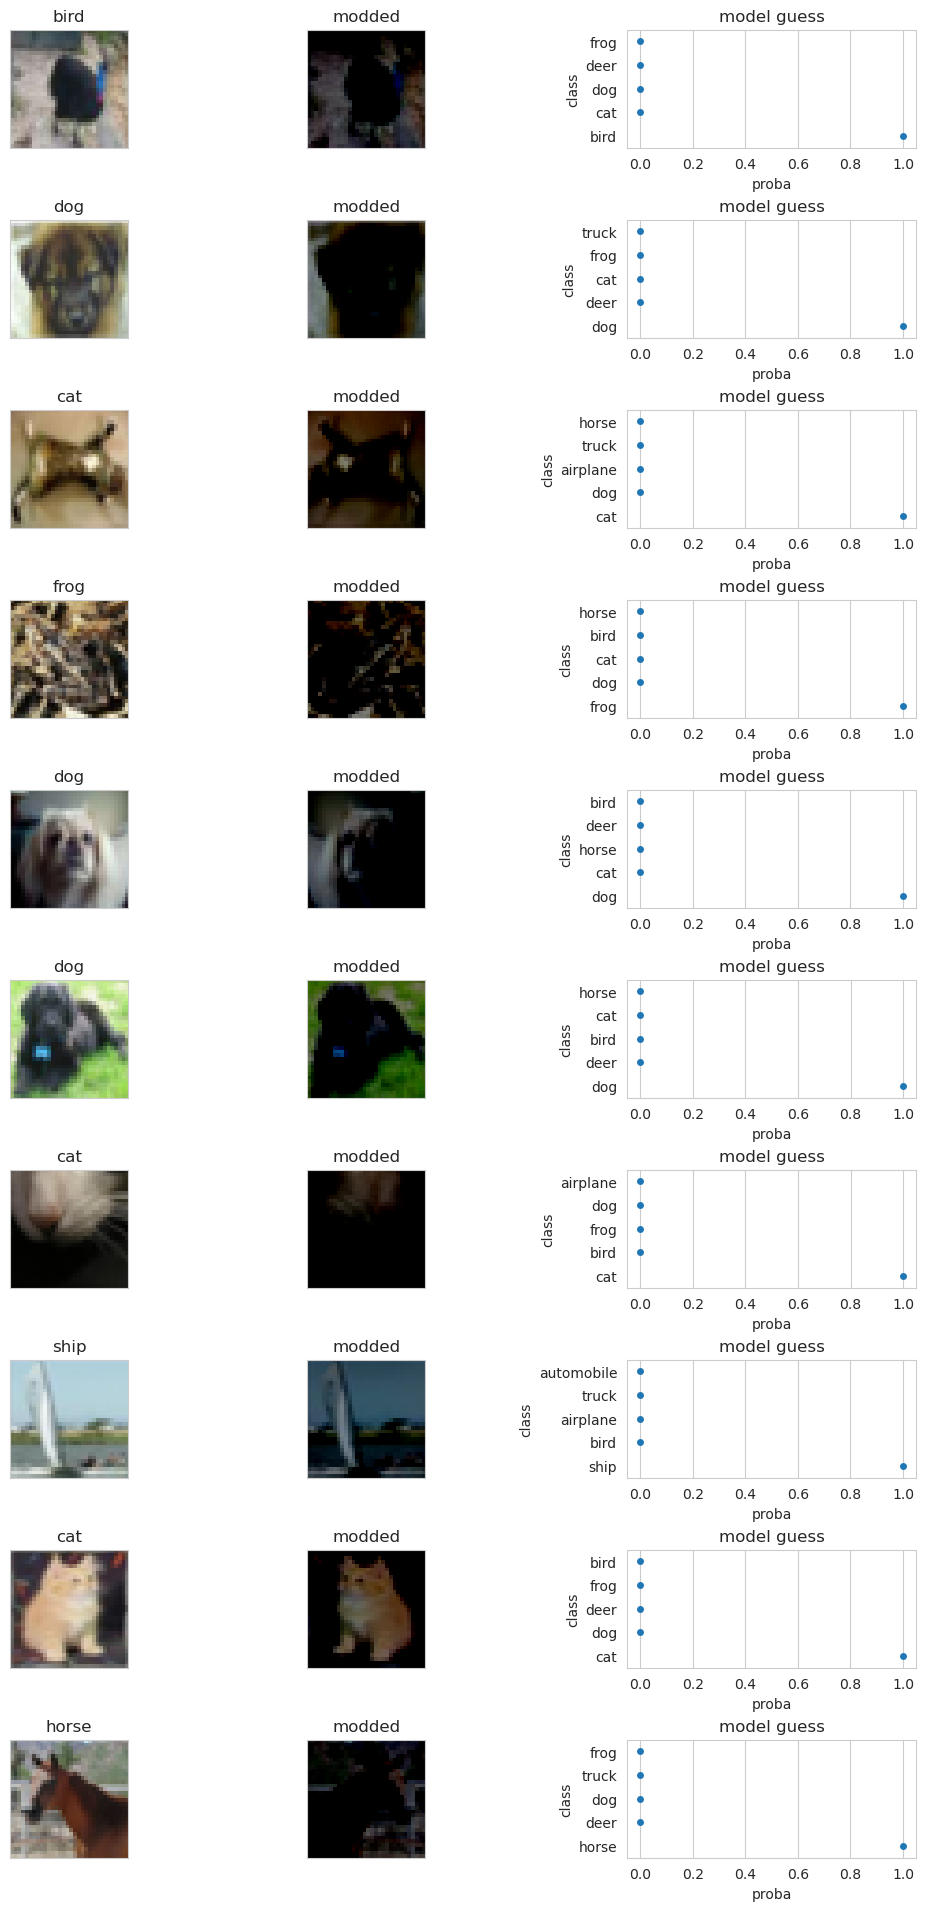

In [26]:
res_110_cifar = ResNetCIFAR10(18, res_type=1)
res_110_cifar.load_state_dict(torch.load("model/res_110_cifar/final_checkpoint")["model"])
res_110_cifar.eval()

num = 10

test_data = CIFAR10(root=data_path, train=False, transform=T.ToTensor(), download=False)

preview_dataloader = DataLoader(test_data, batch_size=num, shuffle=True)

fig, ax = plt.subplots(nrows=num, ncols=3, figsize=(10, int(1.8 * num) + 1), constrained_layout=True)

for X, y in preview_dataloader:
    break

for i in range(num):
    ax[i, 0].imshow(X[i].permute(1, 2, 0))
    ax[i, 0].set(title=val_data.classes[int(y[i])], xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    X_mod = val_transform(T.ToPILImage()(X[i]))
    ax[i, 1].imshow(torch.maximum(X_mod, torch.zeros_like(X_mod)).permute(1, 2, 0))
    ax[i, 1].set(title="modded", xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    proba = res_110_cifar.predict_proba(X_mod)[0]
    data = pd.DataFrame(columns=["class", "proba"])
    
    for x in torch.argsort(proba)[-5:]:
        data.loc[len(data)] = {
            "class": val_data.classes[int(x)],
            "proba": float(proba[x]),
        }

    sns.stripplot(data, x="proba", y="class", ax=ax[i, 2])
    ax[i, 2].set_title("model guess")
plt.show(fig)